# TIME SERIES ANALYSIS 

Here I will load historical Dollar-Yen exchange rate futures data and apply time series analysis and modeling to determine whether there is any predictable behavior.

# PREPERATIONS

## Import Libraries

In [11]:
import pandas as pd
%matplotlib inline
from pathlib import Path
import statsmodels
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
import arch
from arch import arch_model
import numpy as np

## Import Data
Here I will load the historical Dollar-Yen exchange rate futures data using Path and Pandas.

In [12]:
# The continuous chain of the futures contracts that are 1 month to expiration.
yen_futures = pd.read_csv(Path("historical_yen.csv"), index_col="Date", infer_datetime_format=True, parse_dates=True)
yen_futures.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1976-08-02,3398.0,3401.0,3398.0,3401.0,NaN,3401.0,2.0,1.0
1976-08-03,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-04,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-05,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-06,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0


In [13]:
# I will begin my research on January 1st, 1990.
yen_futures = yen_futures.loc["1990-01-01":, :]
yen_futures.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1990-01-02,6954.0,6954.0,6835.0,6847.0,NaN,6847.0,48336.0,51473.0
1990-01-03,6877.0,6910.0,6865.0,6887.0,NaN,6887.0,38206.0,53860.0
1990-01-04,6937.0,7030.0,6924.0,7008.0,NaN,7008.0,49649.0,55699.0
1990-01-05,6952.0,6985.0,6942.0,6950.0,NaN,6950.0,29944.0,53111.0
1990-01-08,6936.0,6972.0,6936.0,6959.0,NaN,6959.0,19763.0,52072.0


# DATA ANALYSIS

## Initial Time-Series Plotting

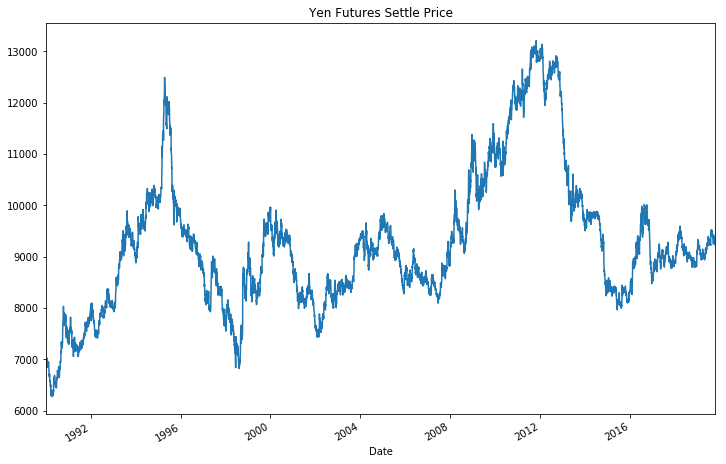

In [14]:
# Here I will plot the Settle price to see if there are any trends.
yen_futures["Settle"].plot(title="Yen Futures Settle Price", figsize=(12,8))

From plotting the Settle price above I can see that there is an overall upward trend. 

---

## Decomposition With Mr. Hodrick-Prescott

Here I will use a Hodrick-Prescott filter to decompose or breakdown the settle plot found above. The idea of breaking down the plot is pulling out the different compononents that make the line we see above. A time series is composed of level, trend, periodicity, and residual. As already stated we can predict that there will be an overall upward trend, but lets find out. 

In [15]:
# Here I will specifically break the time series into noise/residual and trend.
ts_noise,ts_trend=sm.tsa.filters.hpfilter(yen_futures["Settle"])

In [16]:
settle_price_df=pd.DataFrame({"Date":yen_futures.index,"Settle":yen_futures["Settle"],"Noise":ts_noise,"Trend":ts_trend}).set_index("Date")

In [17]:
settle_price_df.head()

,Settle,Noise,Trend
Date,,,
1990-01-02,6847.0,-61.503967,6908.503967
1990-01-03,6887.0,-21.799756,6908.799756
1990-01-04,7008.0,98.942896,6909.057104
1990-01-05,6950.0,40.776052,6909.223948
1990-01-08,6959.0,49.689938,6909.310062


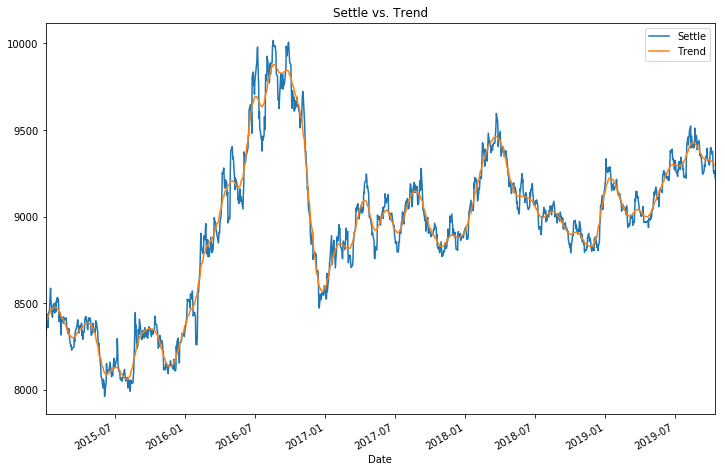

In [18]:
# Here I will overlay the trend data on the Settle plot so we can see how powerful this trend is.
ax=settle_price_df["Settle"].loc["2015":].plot(label="Settle",legend=True)
settle_price_df["Trend"].loc["2015":].plot(ax=ax,figsize=(12,8),title="Settle vs. Trend",label="Trend",legend=True)

The orange line is a representation of pure trend. One can see that it is a smooth line because all of the level and noise is gone. We can still see that it has a huge impact on this plot though because it is almost right in line with the settle line. One can see how everything is moving upward as well.

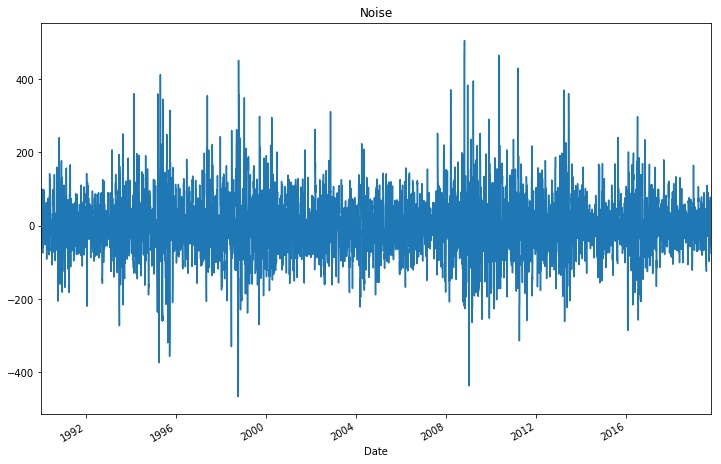

In [19]:
# A plot of pure noise.
settle_price_df["Noise"].plot(title="Noise",figsize=(12,8))

Here one can see the the pure noise data. But, what is actually interesting is that the noise data is actually somewhat staying in a general area. Like our noise has a pattern or trend in itself, this is good, it means that we have stationary data.

---

# Forecasting Returns using an ARMA Model

In [20]:
returns = (yen_futures[["Settle"]].pct_change() * 100)
returns = returns.replace(-np.inf, np.nan).dropna()
returns.tail()

,Settle
Date,
2019-10-09,-0.410601
2019-10-10,-0.369458
2019-10-11,-0.564304
2019-10-14,0.151335
2019-10-15,-0.469509


In [21]:
# Here I will create an ARMA model using statsmodels with order (2,1) 
# 2 representing our AR lags and 1 representing MA lags resepctively.
model=ARMA(returns.values,order=(2,1))

In [23]:
# I then fit the model and assign it to a variable called results.
# This is fitting our model to our data, training it to our data so it will know how to analyze future data and predict.
results=model.fit()

In [24]:
# Here I give a summary of the model results.
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                 7514
Model:                     ARMA(2, 1)   Log Likelihood               -7894.071
Method:                       css-mle   S.D. of innovations              0.692
Date:                Mon, 31 Aug 2020   AIC                          15798.142
Time:                        13:43:33   BIC                          15832.765
Sample:                             0   HQIC                         15810.030
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0063      0.008      0.804      0.422      -0.009       0.022
ar.L1.y       -0.3063      1.277     -0.240      0.810      -2.810       2.197
ar.L2.y       -0.0019      0.019     -0.099      0.921      -0.040       0.036
ma.L1.y        0.2947      1.277      0.231      0.818      -2.209       2.798
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -3.3342           +0.0000j            3.3342            0.5000
AR.2         -157.1635           +0.0000j          157.1635            0.5000
MA.1           -3.3930           +0.0000j            3.3930            0.5000
-----------------------------------------------------------------------------
"""

All my P Values are above 0.05 which means that this model is not a good fit for the data, so I have to be weary of these results.

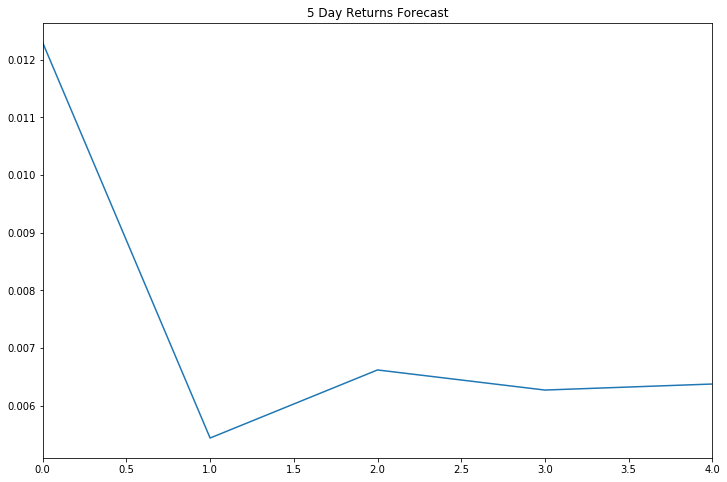

In [25]:
# Here I plot a 5 day returns forecast so we can visualize our data based off our ARMA model.
arma_forecast=pd.DataFrame(results.forecast(steps=5)[0])
arma_forecast.plot(title="5 Day Returns Forecast",figsize=(12,8),legend=False)

In [14]:
# Here I give the numbers if one would like to see them. 
arma_forecast

,0
0,0.012294
1,0.005437
2,0.006618
3,0.006269
4,0.006374


---

# Forecasting the Settle Price using an ARIMA Model

In [24]:
# Here I declare an ARIMA model and assign it to the variable arima_model. I use 5,1,1 for my order representing p,d,q.
# 5=p=AR lag, 1=d=Diference, and q=1=MA lag. What makes the ARIMA model special is that it does the difference for us with d.
# We would have to use the .diff() ourselves for example on non-stationary data. Even though our data is pretty stationary I believe.
arima_model=ARIMA(yen_futures["Settle"].values,order=(5,1,1))

In [24]:
# Again I have to fit the model, acclimate it to our data so that it will know how to predict. 
arima_results=arima_model.fit()

In [25]:
# Here I give a summary of our model results.
arima_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                 7514
Model:                 ARIMA(5, 1, 1)   Log Likelihood              -41944.619
Method:                       css-mle   S.D. of innovations             64.281
Date:                Thu, 27 Aug 2020   AIC                          83905.238
Time:                        00:41:19   BIC                          83960.635
Sample:                             1   HQIC                         83924.259
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3161      0.700      0.452      0.652      -1.056       1.688
ar.L1.D.y      0.2823      0.699      0.404      0.686      -1.088       1.652
ar.L2.D.y      0.0007      0.016      0.043      0.966      -0.030       0.032
ar.L3.D.y     -0.0126      0.012     -1.032      0.302      -0.037       0.011
ar.L4.D.y     -0.0137      0.015     -0.889      0.374      -0.044       0.016
ar.L5.D.y     -0.0012      0.018     -0.064      0.949      -0.036       0.034
ma.L1.D.y     -0.2973      0.699     -0.425      0.671      -1.667       1.073
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.8919           -1.3785j            2.3409           -0.1002
AR.2            1.8919           +1.3785j            2.3409            0.1002
AR.3           -2.2707           -3.0203j            3.7787           -0.3526
AR.4           -2.2707           +3.0203j            3.7787            0.3526
AR.5          -11.0894           -0.0000j           11.0894           -0.5000
MA.1            3.3633           +0.0000j            3.3633            0.0000
-----------------------------------------------------------------------------
"""

Because all of my P values are above 0.05 this model is not a good fit. This is not the best model for my data so I need to be weary about how these results look.

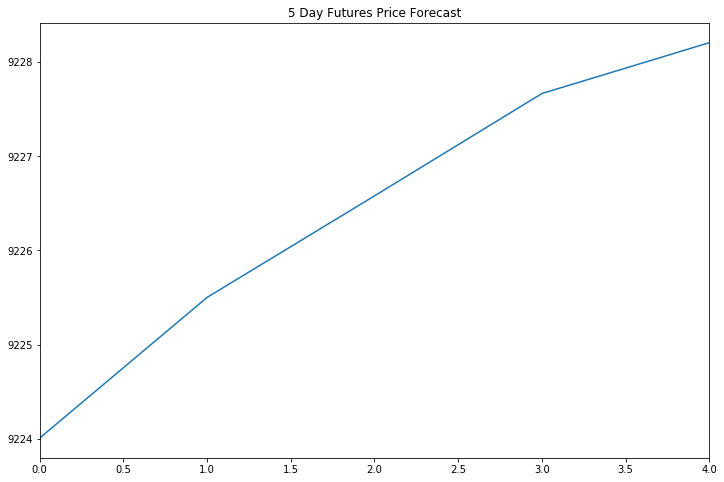

In [26]:
# A 5 Day forecast based off our ARIMA model.
pd.DataFrame(arima_results.forecast(steps=5)[0]).plot(title="5 Day Futures Price Forecast", figsize=(12,8), legend=False)

---

# Volatility Forecasting with GARCH

The higher the volatility of something the higher the risk. High volatility can affect prices. Volatility can beget volatility and also there's the idea that volatility and returns tend to cluster. The GARCH model is specifically designed to take advantage of this idea. The GARCH model is used to predict volatility. Here I will create a GARCH model to analyze the volatility of our yen.

In [34]:
# Here I estimate a GARCH model by trying a p/ AR lag of 2, and a q/ MA lag of 1.
garch_model=arch_model(returns,mean="Zero",vol="GARCH",p=2,q=1)
garch_results=garch_model.fit(disp="off")

In [35]:
# Here I give a summary of the GARCH results.
garch_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                       Zero Mean - GARCH Model Results                        
==============================================================================
Dep. Variable:                 Settle   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -7461.93
Distribution:                  Normal   AIC:                           14931.9
Method:            Maximum Likelihood   BIC:                           14959.6
                                        No. Observations:                 7514
Date:                Mon, Aug 31 2020   Df Residuals:                     7510
Time:                        13:57:29   Df Model:                            4
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      4.2896e-03  2.057e-03      2.085  3.708e-02  [2.571e-04,8.322e-03]
alpha[1]       0.0381  1.282e-02      2.970  2.974e-03  [1.295e-02,6.321e-02]
alpha[2]       0.0000  1.703e-02      0.000      1.000 [-3.338e-02,3.338e-02]
beta[1]        0.9536  1.420e-02     67.135      0.000      [  0.926,  0.981]
=============================================================================

Covariance estimator: robust
"""

In [28]:
# Here I find the last day of the dataset so I can begin my forecast.
last_day = returns.index.max().strftime('%Y-%m-%d')
last_day

'2019-10-15'

In [29]:
# I define my horizon as 5 to create a 5 day forecast of volatility.
forecast_horizon = 5

In [29]:
# I start start the forecast using the last_day calculated above so it can predict from the very last piece of real data.
forecasts=garch_results.forecast(horizon=forecast_horizon, start=last_day)

In [36]:
# I then annualize the forecast.
intermediate = np.sqrt(forecasts.variance.dropna() * 252)
intermediate.head()

,h.1,h.2,h.3,h.4,h.5
Date,,,,,
2019-10-15,7.434048,7.475745,7.516867,7.557426,7.597434


In [37]:
# I then transpose the forecast just so that I can plot it easier.
final = intermediate.dropna().T
final.head()

Date,2019-10-15 00:00:00
h.1,7.434048
h.2,7.475745
h.3,7.516867
h.4,7.557426
h.5,7.597434


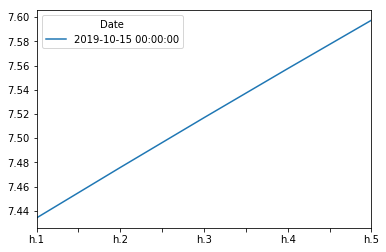

In [32]:
# Here I plot the final forecast so we can visualize the data.
final.plot()

---

# Conclusions

**Time Series Analysis...should I buy?**

In my ARMA model, one can see that the 5 day forecast has a huge decline, but at the same time while the return amounts decrease, each day still has positive returns. We can then look at the ARIMA and find positive settle's prices daily. When we then look at the GARCH forecast, the volatility is predicted to go straight up, on my plot you can see a completely positive slope. This could go with the cluster idea that when volatility occurs returns react at the same time. With high volatility and the fact that my ARMA is giving me declining returns regardless I would be hesitant to buy the yen. I would need more information, look at my risk to reward. I would also begin to look at other factors like the timing of my buy. This could be the top of a drop. Volatility is high and the forecast is looking like declining returns. At this point I would go into the live ticker to make my final decisions. I would be very interested though because again, even when we first looked at the data one could see that the raw settle data had a solid positive trend and our noise was stationary. This means the trend was the biggest factor in the raw data itself, and even if the return amounts declined the ARMA still forecasted positive returns and the ARIMA has positive settle prices. Maybe I would first look at the maximum profit I could make analyzing the best day close from my forecast data. Then again analyze my risk to reward. I also have to add that the P values for both my ARMA and ARIMA were above 0.05 so we have to be wearty of the data regardless too. 

**Risk Analysis**

As stated above the risk of the yen is expected to sky rocket. My GARCH forecast has a straight positive sloped line. Each day the volatility increases. 

**Confidence In These Models...would I trade these?**

I definetely feel like these are an awesome tool to have in my toolkit. Would I completely rely on them? No. I believe in technical analysis and sentimental analysis with some sprinkles of fundamental analysis. I am learning these algorithms and models and again I believe that they are awesome to have with me in my toolkit. I believe that noise is important though, noise is reality, noise is life. But this would be a 70% factor in my decision. Like I stated above, I would then start looking at the other data. This would be my start of interest. I would then have to look at the dollar index, what is happening in Japanese markets and analyze the live chart to see trends and etc. Again, my p values also were not good, so I have to be careful.
